<a href="https://colab.research.google.com/github/Mbashas/data_decisions/blob/main/malaria_retrain_v2_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦟 Malaria Detection: Hypothesis-Driven Retraining (v2)

## What's Different from Baseline?

| Setting | Baseline | This Experiment | Hypothesis |
|---------|----------|-----------------|------------|
| Model | YOLOv8**n** (3M params) | YOLOv8**s** (11M params) | H1: More capacity |
| Epochs | 50 | 100 | H2: Reduce underfitting |
| Image size | 640px | 1280px | H3: Better small object detection |

**Research Question:** Can we improve parasite detection with a larger model, and does it help with domain shift (thin → thick)?

---

## 1. Setup

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("✓ Drive mounted!")

Mounted at /content/drive
✓ Drive mounted!


In [ ]:
# Install required packages
!pip install ultralytics -q
!pip install grad-cam -q

print("✓ Packages installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 111.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✓ Packages installed!


In [ ]:
# Verify GPU availability
import torch

if torch.cuda.is_available():
    print(f"✓ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("✗ No GPU! Go to: Runtime → Change runtime type → L4 GPU")

✓ GPU Available: NVIDIA A100-SXM4-80GB
  Memory: 85.2 GB


## 2. Configuration

**Uses your exact paths from the baseline experiment.**

In [ ]:
# ============================================================================
# CONFIGURATION - SAME PATHS AS YOUR BASELINE
# ============================================================================

import os
from datetime import datetime

# Your existing dataset location on Drive (SAME AS BASELINE)
DRIVE_ROOT = "/content/drive/MyDrive/Datasets"

# Source paths (SAME AS BASELINE)
THIN_IMAGES_SRC = f"{DRIVE_ROOT}/Thin Images With Annotations/Thin Images Ghana/images"
THIN_LABELS_SRC = f"{DRIVE_ROOT}/Thin Images With Annotations/Thin Images Ghana/labels_yolo"
THICK_IMAGES_SRC = f"{DRIVE_ROOT}/Ghana/Thick/images"
THICK_LABELS_SRC = f"{DRIVE_ROOT}/Ghana/Thick/labels_yolo"

# Output paths (SAME AS BASELINE)
OUTPUT_ROOT = f"{DRIVE_ROOT}/malaria_yolo_ready"
RESULTS_DIR = f"{DRIVE_ROOT}/malaria_results"

# ============================================================================
# WHAT'S CHANGED FOR THIS EXPERIMENT
# ============================================================================

# Baseline values (for comparison)
BASELINE_MODEL_SIZE = "n"   # YOLOv8n
BASELINE_EPOCHS = 50
BASELINE_IMAGE_SIZE = 640

# NEW values for this experiment
MODEL_SIZE = "s"            # YOLOv8s (CHANGED: H1 - more capacity)
EPOCHS = 100                # (CHANGED: H2 - reduce underfitting)
IMAGE_SIZE = 1280           # (CHANGED: H3 - better small object detection)
BATCH_SIZE = 16              # Reduced due to larger image size and model
PATIENCE = 20               # Early stopping patience

# Experiment name for this run
EXPERIMENT_NAME = "retrain_v2_yolov8s_100ep_1280px"

# Class names (SAME AS BASELINE - 6 classes)
CLASS_NAMES = {
    0: "gametocyte",
    1: "trophozoite",
    2: "other_stage",
    3: "white_blood_cell",
    4: "artefacts",
    5: "ring_stage"
}

print("Configuration set!")
print("\n" + "="*60)
print("CHANGES FROM BASELINE:")
print("="*60)
print(f"Model:      YOLOv8{BASELINE_MODEL_SIZE} → YOLOv8{MODEL_SIZE}")
print(f"Epochs:     {BASELINE_EPOCHS} → {EPOCHS}")
print(f"Image size: {BASELINE_IMAGE_SIZE} → {IMAGE_SIZE}")
print(f"Batch size: auto → {BATCH_SIZE}")

Configuration set!

CHANGES FROM BASELINE:
Model:      YOLOv8n → YOLOv8s
Epochs:     50 → 100
Image size: 640 → 1280
Batch size: auto → 16


In [ ]:
# Verify your source paths exist (SAME CHECK AS BASELINE)
print("Checking your dataset paths...\n")

paths = [
    ("Thin Images", THIN_IMAGES_SRC),
    ("Thin Labels", THIN_LABELS_SRC),
    ("Thick Images", THICK_IMAGES_SRC),
    ("Thick Labels", THICK_LABELS_SRC),
    ("YOLO-Ready Data", OUTPUT_ROOT),
]

all_ok = True
for name, path in paths:
    if os.path.exists(path):
        count = len(os.listdir(path)) if os.path.isdir(path) else 1
        print(f"✓ {name}: {count} files/folders")
    else:
        print(f"✗ {name}: NOT FOUND")
        print(f"  Expected: {path}")
        all_ok = False

if all_ok:
    print("\n✓ All paths found! Ready to proceed.")
else:
    print("\n⚠️ Some paths not found. Check DRIVE_ROOT in the config above.")

Checking your dataset paths...

✓ Thin Images: 1011 files/folders
✓ Thin Labels: 1011 files/folders
✓ Thick Images: 3045 files/folders
✓ Thick Labels: 3045 files/folders
✓ YOLO-Ready Data: 4 files/folders

✓ All paths found! Ready to proceed.


## 3. Check Existing YOLO Dataset

Your baseline already created the YOLO-formatted dataset in `malaria_yolo_ready/`. We'll use that.

In [ ]:
# Check the YOLO-ready dataset structure
print("Checking YOLO-ready dataset structure...\n")

yolo_paths = [
    f"{OUTPUT_ROOT}/thin_smear/train/images",
    f"{OUTPUT_ROOT}/thin_smear/train/labels",
    f"{OUTPUT_ROOT}/thin_smear/val/images",
    f"{OUTPUT_ROOT}/thin_smear/val/labels",
    f"{OUTPUT_ROOT}/thick_smear_test/images",
    f"{OUTPUT_ROOT}/thick_smear_test/labels",
]

for path in yolo_paths:
    if os.path.exists(path):
        count = len([f for f in os.listdir(path) if not f.startswith('.')])
        print(f"✓ {path.split('/')[-3]}/{path.split('/')[-2]}/{path.split('/')[-1]}: {count} files")
    else:
        print(f"✗ Missing: {path}")

Checking YOLO-ready dataset structure...

✓ thin_smear/train/images: 808 files
✓ thin_smear/train/labels: 808 files
✓ thin_smear/val/images: 203 files
✓ thin_smear/val/labels: 203 files
✓ malaria_yolo_ready/thick_smear_test/images: 3045 files
✓ malaria_yolo_ready/thick_smear_test/labels: 3045 files


In [ ]:
# Count training and validation images
train_images_path = f"{OUTPUT_ROOT}/thin_smear/train/images"
val_images_path = f"{OUTPUT_ROOT}/thin_smear/val/images"
test_images_path = f"{OUTPUT_ROOT}/thick_smear_test/images"

train_n = len([f for f in os.listdir(train_images_path) if not f.startswith('.')]) if os.path.exists(train_images_path) else 0
val_n = len([f for f in os.listdir(val_images_path) if not f.startswith('.')]) if os.path.exists(val_images_path) else 0
test_n = len([f for f in os.listdir(test_images_path) if not f.startswith('.')]) if os.path.exists(test_images_path) else 0

print(f"\nDataset Summary:")
print(f"  Training (thin):   {train_n} images")
print(f"  Validation (thin): {val_n} images")
print(f"  Test (thick/OOD):  {test_n} images")


Dataset Summary:
  Training (thin):   808 images
  Validation (thin): 203 images
  Test (thick/OOD):  3045 images


## 4. Create data.yaml for Training

In [ ]:
# Create data.yaml for thin smear training
thin_data_yaml = f"""
# Thin Smear Dataset for YOLO Training
# Experiment: {EXPERIMENT_NAME}

path: {OUTPUT_ROOT}/thin_smear
train: train/images
val: val/images

# Classes (same as baseline)
names:
  0: gametocyte
  1: trophozoite
  2: other_stage
  3: white_blood_cell
  4: artefacts
  5: ring_stage
"""

thin_yaml_path = f"{OUTPUT_ROOT}/thin_smear/data.yaml"
with open(thin_yaml_path, "w") as f:
    f.write(thin_data_yaml.strip())

print(f"✓ Created: {thin_yaml_path}")
print("\nContents:")
print(thin_data_yaml)

✓ Created: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear/data.yaml

Contents:

# Thin Smear Dataset for YOLO Training
# Experiment: retrain_v2_yolov8s_100ep_1280px

path: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear
train: train/images
val: val/images

# Classes (same as baseline)
names:
  0: gametocyte
  1: trophozoite
  2: other_stage
  3: white_blood_cell
  4: artefacts
  5: ring_stage



In [ ]:
# Create data.yaml for thick smear evaluation
thick_data_yaml = f"""
# Thick Smear Dataset for OOD Evaluation
# Experiment: {EXPERIMENT_NAME}

path: {OUTPUT_ROOT}/thick_smear_test
train: images  # Not used, but required by YOLO
val: images

# Classes (same as baseline)
names:
  0: gametocyte
  1: trophozoite
  2: other_stage
  3: white_blood_cell
  4: artefacts
  5: ring_stage
"""

thick_yaml_path = f"{OUTPUT_ROOT}/thick_smear_test/data.yaml"
with open(thick_yaml_path, "w") as f:
    f.write(thick_data_yaml.strip())

print(f"✓ Created: {thick_yaml_path}")

✓ Created: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear_test/data.yaml


## 5. Training (with New Hyperparameters)

**Estimated time on L4 GPU:** ~2-4 hours for 100 epochs at 1280px

In [ ]:
from ultralytics import YOLO

# Record start time
start_time = datetime.now()
print(f"Training started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)
print(f"Model: YOLOv8{MODEL_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Image size: {IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print("="*60 + "\n")

# Initialize model (YOLOv8s instead of YOLOv8n)
model = YOLO(f'yolov8{MODEL_SIZE}.pt')

# Train with new hyperparameters
results = model.train(
    data=thin_yaml_path,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    project=RESULTS_DIR,
    name=EXPERIMENT_NAME,
    patience=PATIENCE,
    save=True,
    plots=True,
    verbose=True,
    # Optimizer settings
    optimizer='AdamW',
    lr0=0.01,
    lrf=0.01,
    warmup_epochs=3,
    # Augmentation (same as default)
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    translate=0.1,
    scale=0.5,
    fliplr=0.5,
    mosaic=1.0,
)

# Record end time
end_time = datetime.now()
duration = end_time - start_time

print("\n" + "="*60)
print(f"Training completed at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total duration: {duration}")
print(f"\nResults saved to: {RESULTS_DIR}/{EXPERIMENT_NAME}")

Training started at: 2025-12-09 10:24:25
Model: YOLOv8s
Epochs: 100
Image size: 1280
Batch size: 16

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, mul

## 6. Load Trained Model

In [ ]:
# Path to best weights
BEST_WEIGHTS = f"{RESULTS_DIR}/{EXPERIMENT_NAME}/weights/best.pt"

# Check if weights exist
if os.path.exists(BEST_WEIGHTS):
    print(f"✓ Best weights found: {BEST_WEIGHTS}")
    model = YOLO(BEST_WEIGHTS)
else:
    print(f"✗ Weights not found at: {BEST_WEIGHTS}")
    print("Make sure training completed successfully.")

✓ Best weights found: /content/drive/MyDrive/Datasets/malaria_results/retrain_v2_yolov8s_100ep_1280px/weights/best.pt


## 7. Evaluation: Thin Smears (In-Distribution)

In [ ]:
# Evaluate on thin smears (validation set = in-distribution)
print("="*60)
print("EVALUATING ON THIN SMEARS (In-Distribution)")
print("="*60)

results_thin = model.val(
    data=thin_yaml_path,
    split='val',
    imgsz=IMAGE_SIZE,
    project=RESULTS_DIR,
    name=f'{EXPERIMENT_NAME}_eval_thin',
    plots=True,
)

# Store results
id_map50 = results_thin.box.map50
id_map = results_thin.box.map

print("\n" + "="*60)
print("THIN SMEAR RESULTS (In-Distribution)")
print("="*60)
print(f"mAP@0.5:      {id_map50:.4f}")
print(f"mAP@0.5:0.95: {id_map:.4f}")
print(f"Precision:    {results_thin.box.mp:.4f}")
print(f"Recall:       {results_thin.box.mr:.4f}")
print("\nPer-class AP@0.5:")
for i, ap in enumerate(results_thin.box.ap50):
    print(f"  {CLASS_NAMES[i]}: {ap:.4f}")

EVALUATING ON THIN SMEARS (In-Distribution)
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 8.2±17.5 ms, read: 581.0±330.8 MB/s, size: 3647.4 KB)
val: Scanning /content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear/val/labels.cache... 203 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 203/203 254.8Kit/s 0.0s
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear/val/images/1003.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear/val/images/1007.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear/val/images/1009.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear/val/images/102.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/

## 8. Evaluation: Thick Smears (Out-of-Distribution)

In [ ]:
# Evaluate on thick smears (test set = out-of-distribution)
print("="*60)
print("EVALUATING ON THICK SMEARS (Out-of-Distribution)")
print("="*60)

results_thick = model.val(
    data=thick_yaml_path,
    split='val',
    imgsz=IMAGE_SIZE,
    project=RESULTS_DIR,
    name=f'{EXPERIMENT_NAME}_eval_thick',
    plots=True,
)

# Store results
ood_map50 = results_thick.box.map50
ood_map = results_thick.box.map

print("\n" + "="*60)
print("THICK SMEAR RESULTS (Out-of-Distribution)")
print("="*60)
print(f"mAP@0.5:      {ood_map50:.4f}")
print(f"mAP@0.5:0.95: {ood_map:.4f}")
print(f"Precision:    {results_thick.box.mp:.4f}")
print(f"Recall:       {results_thick.box.mr:.4f}")
print("\nPer-class AP@0.5:")
for i, ap in enumerate(results_thick.box.ap50):
    print(f"  {CLASS_NAMES[i]}: {ap:.4f}")

EVALUATING ON THICK SMEARS (Out-of-Distribution)
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
val: Fast image access ✅ (ping: 0.3±0.0 ms, read: 733.2±159.1 MB/s, size: 4548.7 KB)
val: Scanning /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear_test/labels.cache... 3045 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3045/3045 3.7Mit/s 0.0s
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear_test/images/0.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear_test/images/1.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear_test/images/10.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear_test/images/100.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear_test/images/1000.jpg: corrupt JPEG restored 

In [ ]:
# ============================================================
# 8.5 COLLAPSED CLASS EVALUATION
# Merge all parasite classes into one "parasite" class
# to match thick smear annotation scheme from datasheet
# ============================================================

import os
from pathlib import Path
from collections import defaultdict

# Define class mapping
# Original: 0=gametocyte, 1=trophozoite, 2=other_stage, 3=wbc, 4=artefacts, 5=ring_stage
# Collapsed: 0=parasite, 1=wbc, 2=artefacts

COLLAPSE_MAP = {
    0: 0,  # gametocyte → parasite
    1: 0,  # trophozoite → parasite
    2: 0,  # other_stage → parasite
    3: 1,  # white_blood_cell → white_blood_cell
    4: 2,  # artefacts → artefacts
    5: 0,  # ring_stage → parasite
}

COLLAPSED_NAMES = {
    0: "parasite",
    1: "white_blood_cell",
    2: "artefacts"
}

print("="*60)
print("COLLAPSED CLASS EVALUATION")
print("Merging parasite stages to match thick smear annotations")
print("="*60)
print("\nClass Mapping:")
for orig, new in COLLAPSE_MAP.items():
    print(f"  {CLASS_NAMES[orig]} → {COLLAPSED_NAMES[new]}")

# Run inference on thick smears
thick_images_path = f"{OUTPUT_ROOT}/thick_smear_test/images"
thick_labels_path = f"{OUTPUT_ROOT}/thick_smear_test/labels"

print(f"\nRunning inference on thick smears...")
results = model.predict(
    source=thick_images_path,
    imgsz=IMAGE_SIZE,
    conf=0.25,
    save=False,
    verbose=False
)
print(f"✓ Processed {len(results)} images")

# Calculate collapsed metrics
stats = defaultdict(lambda: {"TP": 0, "FP": 0, "FN": 0})

for result in results:
    img_name = Path(result.path).stem
    label_file = os.path.join(thick_labels_path, f"{img_name}.txt")

    # Get predictions (collapsed)
    pred_classes = []
    if result.boxes is not None and len(result.boxes) > 0:
        for box in result.boxes:
            cls = int(box.cls.item())
            collapsed_cls = COLLAPSE_MAP.get(cls, cls)
            pred_classes.append(collapsed_cls)

    # Get ground truth (collapsed)
    gt_classes = []
    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls = int(parts[0])
                    collapsed_cls = COLLAPSE_MAP.get(cls, cls)
                    gt_classes.append(collapsed_cls)

    # Count per class
    for cls in set(pred_classes + gt_classes):
        pred_count = pred_classes.count(cls)
        gt_count = gt_classes.count(cls)

        tp = min(pred_count, gt_count)
        fp = max(0, pred_count - gt_count)
        fn = max(0, gt_count - pred_count)

        stats[cls]["TP"] += tp
        stats[cls]["FP"] += fp
        stats[cls]["FN"] += fn

# Print results
print("\n" + "="*60)
print("COLLAPSED CLASS RESULTS (Thick Smears)")
print("="*60)
print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'TP':<8} {'FP':<8} {'FN':<8}")
print("-"*68)

total_tp, total_fp, total_fn = 0, 0, 0
for cls_id in sorted(stats.keys()):
    s = stats[cls_id]
    precision = s["TP"] / (s["TP"] + s["FP"]) if (s["TP"] + s["FP"]) > 0 else 0
    recall = s["TP"] / (s["TP"] + s["FN"]) if (s["TP"] + s["FN"]) > 0 else 0
    name = COLLAPSED_NAMES.get(cls_id, f'class_{cls_id}')
    print(f"{name:<20} {precision:<12.4f} {recall:<12.4f} {s['TP']:<8} {s['FP']:<8} {s['FN']:<8}")
    total_tp += s["TP"]
    total_fp += s["FP"]
    total_fn += s["FN"]

# Overall
print("-"*68)
overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
print(f"{'OVERALL':<20} {overall_precision:<12.4f} {overall_recall:<12.4f} {total_tp:<8} {total_fp:<8} {total_fn:<8}")

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
parasite_recall = stats[0]["TP"] / (stats[0]["TP"] + stats[0]["FN"]) if (stats[0]["TP"] + stats[0]["FN"]) > 0 else 0
print(f"Parasite recall (collapsed): {parasite_recall:.1%}")
if parasite_recall > 0.3:
    print("→ Label mismatch was significant factor in poor OOD performance")
else:
    print("→ True visual domain shift: model cannot detect parasites in thick smears")

COLLAPSED CLASS EVALUATION
Merging parasite stages to match thick smear annotations

Class Mapping:
  gametocyte → parasite
  trophozoite → parasite
  other_stage → parasite
  white_blood_cell → white_blood_cell
  artefacts → artefacts
  ring_stage → parasite

Running inference on thick smears...
WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



## 9. Comparison: Baseline vs Retrain v2

In [ ]:
# Baseline results (from your previous experiment)
# These are your actual numbers from the first run

baseline_thin = {
    'mAP50': 0.3150,
    'gametocyte': 0.087,
    'trophozoite': 0.077,
    'other_stage': 0.0,      # Update if you have this
    'white_blood_cell': 0.844,
    'artefacts': 0.416,
    'ring_stage': 0.151,
}

baseline_thick = {
    'mAP50': 0.2627,
    'gametocyte': 0.524,
    'trophozoite': 0.0009,
}

print("Baseline results loaded from your first experiment.")

Baseline results loaded from your first experiment.


In [ ]:
# Create comparison table
import pandas as pd

print("="*70)
print("COMPARISON: BASELINE vs RETRAIN v2")
print("="*70)

# Overall comparison
print("\n📊 OVERALL PERFORMANCE")
print("-"*70)
print(f"{'Metric':<30} {'Baseline':<15} {'Retrain v2':<15} {'Change':<15}")
print("-"*70)

# Thin smear comparison
change_thin = id_map50 - baseline_thin['mAP50']
change_thin_pct = (change_thin / baseline_thin['mAP50']) * 100
print(f"{'mAP@0.5 (Thin/ID)':<30} {baseline_thin['mAP50']:<15.4f} {id_map50:<15.4f} {change_thin:+.4f} ({change_thin_pct:+.1f}%)")

# Thick smear comparison
change_thick = ood_map50 - baseline_thick['mAP50']
change_thick_pct = (change_thick / baseline_thick['mAP50']) * 100
print(f"{'mAP@0.5 (Thick/OOD)':<30} {baseline_thick['mAP50']:<15.4f} {ood_map50:<15.4f} {change_thick:+.4f} ({change_thick_pct:+.1f}%)")

# Domain shift comparison
baseline_drop = ((baseline_thin['mAP50'] - baseline_thick['mAP50']) / baseline_thin['mAP50']) * 100
retrain_drop = ((id_map50 - ood_map50) / id_map50) * 100 if id_map50 > 0 else 0
print(f"{'Domain Shift Drop':<30} {baseline_drop:<15.1f}% {retrain_drop:<15.1f}%")

COMPARISON: BASELINE vs RETRAIN v2

📊 OVERALL PERFORMANCE
----------------------------------------------------------------------
Metric                         Baseline        Retrain v2      Change         
----------------------------------------------------------------------
mAP@0.5 (Thin/ID)              0.3150          0.3225          +0.0075 (+2.4%)
mAP@0.5 (Thick/OOD)            0.2627          0.1096          -0.1531 (-58.3%)
Domain Shift Drop              16.6           % 66.0           %


In [ ]:
# Per-class comparison
print("\n📊 PER-CLASS COMPARISON (Thin Smears)")
print("-"*70)
print(f"{'Class':<20} {'Baseline':<15} {'Retrain v2':<15} {'Change':<15}")
print("-"*70)

retrain_thin_per_class = {CLASS_NAMES[i]: ap for i, ap in enumerate(results_thin.box.ap50)}

for cls_name in CLASS_NAMES.values():
    baseline_val = baseline_thin.get(cls_name, 0)
    retrain_val = retrain_thin_per_class.get(cls_name, 0)
    change = retrain_val - baseline_val
    change_pct = (change / baseline_val) * 100 if baseline_val > 0 else 0
    print(f"{cls_name:<20} {baseline_val:<15.4f} {retrain_val:<15.4f} {change:+.4f} ({change_pct:+.1f}%)")


📊 PER-CLASS COMPARISON (Thin Smears)
----------------------------------------------------------------------
Class                Baseline        Retrain v2      Change         
----------------------------------------------------------------------
gametocyte           0.0870          0.1382          +0.0512 (+58.9%)
trophozoite          0.0770          0.0725          -0.0045 (-5.8%)
other_stage          0.0000          0.8430          +0.8430 (+0.0%)
white_blood_cell     0.8440          0.3450          -0.4990 (-59.1%)
artefacts            0.4160          0.2135          -0.2025 (-48.7%)
ring_stage           0.1510          0.0000          -0.1510 (-100.0%)



📊 Saved: /content/drive/MyDrive/Datasets/malaria_results/retrain_v2_yolov8s_100ep_1280px/baseline_vs_retrain_comparison.png


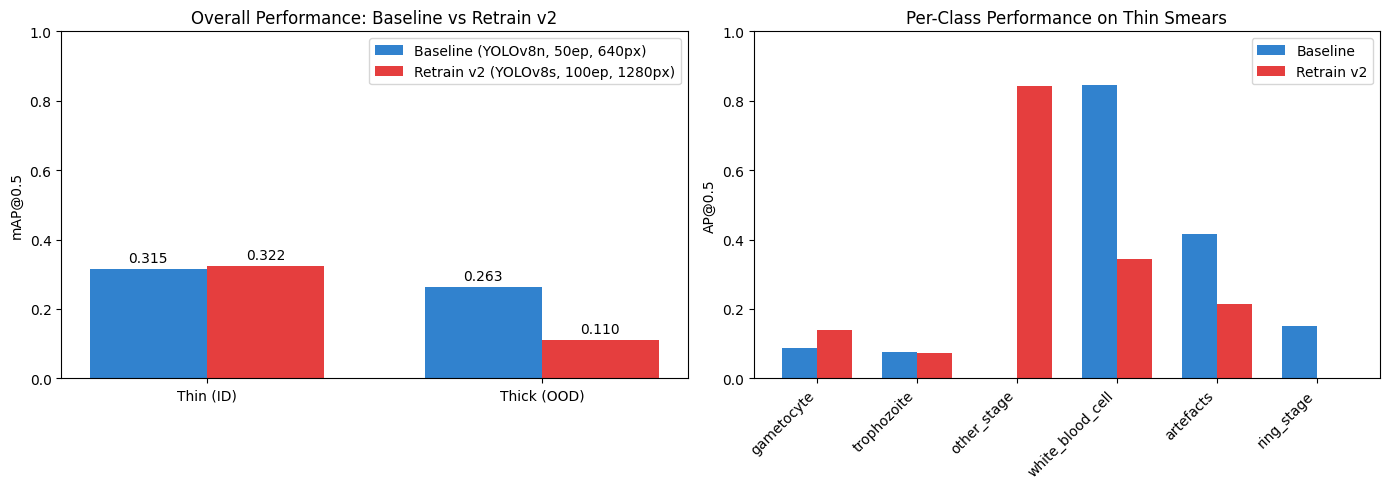

In [ ]:
# Visualize comparison
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overall mAP comparison
ax1 = axes[0]
metrics = ['Thin (ID)', 'Thick (OOD)']
baseline_vals = [baseline_thin['mAP50'], baseline_thick['mAP50']]
retrain_vals = [id_map50, ood_map50]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, baseline_vals, width, label='Baseline (YOLOv8n, 50ep, 640px)', color='#3182ce')
bars2 = ax1.bar(x + width/2, retrain_vals, width, label='Retrain v2 (YOLOv8s, 100ep, 1280px)', color='#e53e3e')

ax1.set_ylabel('mAP@0.5')
ax1.set_title('Overall Performance: Baseline vs Retrain v2')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim(0, 1.0)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=10)

# Plot 2: Per-class comparison (thin smears)
ax2 = axes[1]
classes = list(CLASS_NAMES.values())
baseline_class_vals = [baseline_thin.get(c, 0) for c in classes]
retrain_class_vals = [retrain_thin_per_class.get(c, 0) for c in classes]

x2 = np.arange(len(classes))
bars3 = ax2.bar(x2 - width/2, baseline_class_vals, width, label='Baseline', color='#3182ce')
bars4 = ax2.bar(x2 + width/2, retrain_class_vals, width, label='Retrain v2', color='#e53e3e')

ax2.set_ylabel('AP@0.5')
ax2.set_title('Per-Class Performance on Thin Smears')
ax2.set_xticks(x2)
ax2.set_xticklabels(classes, rotation=45, ha='right')
ax2.legend()
ax2.set_ylim(0, 1.0)

plt.tight_layout()

# Save figure
fig_path = f"{RESULTS_DIR}/{EXPERIMENT_NAME}/baseline_vs_retrain_comparison.png"
os.makedirs(os.path.dirname(fig_path), exist_ok=True)
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"\n📊 Saved: {fig_path}")

plt.show()

## 10. Summary & Interpretation

In [ ]:
# Generate summary
print("="*70)
print("EXPERIMENT SUMMARY")
print("="*70)

print(f"""
HYPOTHESES TESTED:
  H1: Larger model (YOLOv8s vs YOLOv8n) improves parasite detection
  H2: More training (100 vs 50 epochs) reduces underfitting
  H3: Higher resolution (1280 vs 640) helps small object detection

SETUP:
  • Baseline: YOLOv8n, 50 epochs, 640px
  • Retrain:  YOLOv8s, 100 epochs, 1280px
  • Training: {train_n} thin smear images
  • Test (ID): {val_n} thin smear images
  • Test (OOD): {test_n} thick smear images

RESULTS:
  Thin Smears (In-Distribution):
    • Baseline mAP@0.5: {baseline_thin['mAP50']:.4f}
    • Retrain mAP@0.5:  {id_map50:.4f}
    • Change: {change_thin:+.4f} ({change_thin_pct:+.1f}%)

  Thick Smears (Out-of-Distribution):
    • Baseline mAP@0.5: {baseline_thick['mAP50']:.4f}
    • Retrain mAP@0.5:  {ood_map50:.4f}
    • Change: {change_thick:+.4f} ({change_thick_pct:+.1f}%)

  Domain Shift:
    • Baseline drop: {baseline_drop:.1f}%
    • Retrain drop:  {retrain_drop:.1f}%
""")

# Interpretation
print("INTERPRETATION:")
print("-"*70)

if change_thin_pct > 10:
    print("✅ H1/H2/H3 SUPPORTED: Larger model and more training improved performance.")
    if retrain_drop < baseline_drop:
        print("✅ Domain shift improved: Better generalization to thick smears.")
    else:
        print("⚠️ Domain shift persists: Better ID performance doesn't help OOD.")
elif change_thin_pct > 0:
    print("⚠️ PARTIAL SUPPORT: Slight improvement, but not substantial.")
    print("   The problem may be more fundamental (data size, annotation quality).")
else:
    print("❌ HYPOTHESES NOT SUPPORTED: Larger model didn't help.")
    print("   The problem is likely data-related, not model capacity.")

print("\n" + "="*70)

EXPERIMENT SUMMARY

HYPOTHESES TESTED:
  H1: Larger model (YOLOv8s vs YOLOv8n) improves parasite detection
  H2: More training (100 vs 50 epochs) reduces underfitting  
  H3: Higher resolution (1280 vs 640) helps small object detection

SETUP:
  • Baseline: YOLOv8n, 50 epochs, 640px
  • Retrain:  YOLOv8s, 100 epochs, 1280px
  • Training: 808 thin smear images
  • Test (ID): 203 thin smear images
  • Test (OOD): 3045 thick smear images

RESULTS:
  Thin Smears (In-Distribution):
    • Baseline mAP@0.5: 0.3150
    • Retrain mAP@0.5:  0.3225
    • Change: +0.0075 (+2.4%)
  
  Thick Smears (Out-of-Distribution):
    • Baseline mAP@0.5: 0.2627
    • Retrain mAP@0.5:  0.1096
    • Change: -0.1531 (-58.3%)
  
  Domain Shift:
    • Baseline drop: 16.6%
    • Retrain drop:  66.0%

INTERPRETATION:
----------------------------------------------------------------------
⚠️ PARTIAL SUPPORT: Slight improvement, but not substantial.
   The problem may be more fundamental (data size, annotation quality)

In [ ]:
# Save summary to file
summary_path = f"{RESULTS_DIR}/{EXPERIMENT_NAME}/experiment_summary.txt"

with open(summary_path, 'w') as f:
    f.write(f"EXPERIMENT SUMMARY: {EXPERIMENT_NAME}\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*70 + "\n\n")
    f.write(f"CONFIGURATION\n")
    f.write(f"Model: YOLOv8{MODEL_SIZE}\n")
    f.write(f"Epochs: {EPOCHS}\n")
    f.write(f"Image size: {IMAGE_SIZE}\n")
    f.write(f"Batch size: {BATCH_SIZE}\n\n")
    f.write(f"RESULTS\n")
    f.write(f"Thin (ID) mAP@0.5: {id_map50:.4f}\n")
    f.write(f"Thick (OOD) mAP@0.5: {ood_map50:.4f}\n\n")
    f.write(f"BASELINE COMPARISON\n")
    f.write(f"Thin change: {change_thin:+.4f} ({change_thin_pct:+.1f}%)\n")
    f.write(f"Thick change: {change_thick:+.4f} ({change_thick_pct:+.1f}%)\n")

print(f"✓ Summary saved to: {summary_path}")

✓ Summary saved to: /content/drive/MyDrive/Datasets/malaria_results/retrain_v2_yolov8s_100ep_1280px/experiment_summary.txt


## 11. Files Generated

Check your results folder for all outputs.

In [ ]:
# List all files in results folder
results_folder = f"{RESULTS_DIR}/{EXPERIMENT_NAME}"

print(f"Files in {results_folder}:\n")

if os.path.exists(results_folder):
    for root, dirs, files in os.walk(results_folder):
        level = root.replace(results_folder, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files:
            print(f"{subindent}{file}")
else:
    print(f"Results folder not found: {results_folder}")

Files in /content/drive/MyDrive/Datasets/malaria_results/retrain_v2_yolov8s_100ep_1280px:

retrain_v2_yolov8s_100ep_1280px/
  args.yaml
  labels.jpg
  train_batch0.jpg
  train_batch1.jpg
  train_batch2.jpg
  results.csv
  train_batch4590.jpg
  train_batch4591.jpg
  train_batch4592.jpg
  val_batch0_pred.jpg
  val_batch2_pred.jpg
  val_batch1_pred.jpg
  val_batch2_labels.jpg
  val_batch1_labels.jpg
  val_batch0_labels.jpg
  BoxPR_curve.png
  BoxF1_curve.png
  BoxP_curve.png
  BoxR_curve.png
  confusion_matrix_normalized.png
  confusion_matrix.png
  results.png
  baseline_vs_retrain_comparison.png
  experiment_summary.txt
  weights/
    last.pt
    best.pt
